In [1]:
%load_ext autoreload
%autoreload 2
import json
from sklearn.metrics import adjusted_mutual_info_score
from torchvision import datasets
from twosample import utils
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from collections import Counter
import string

In [2]:
num_datasets = 10
matplotlib.rcParams.update({'font.size': 22})
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
figure_path = 'figures/smallscale'
utils.create_directory_if_not_exists(figure_path)

# Discriminability vs. DeepCluster

In [3]:
num_correct_merges_by_affinity_type = []
for affinity_type in ['fast_twosample', 'averagelinkage']:
    num_correct_merges_by_dataset = []
    for dataset_index in range(num_datasets):
        experiment_filename = 'results/3-experiment/imagenet-{}/20x100_{}.json'.format(
            dataset_index, affinity_type)
        with open(experiment_filename) as experiment_file:
            experiment = json.load(experiment_file)
        dataset = datasets.ImageFolder('./datasets/' + experiment['hp']['dataset'])
        initial_clustering = experiment['result']['initial_clustering']
        
        num_correct_merges_history = []
        num_merges = num_correct_merges = 0
        previous_clustering = initial_clustering
        for merge_step in experiment['result']['merges']:
            current_clustering = merge_step['current_clustering']
            cluster_a_majority_category =\
                utils.get_majority_category(dataset,
                                            previous_clustering[merge_step['cluster_a_index']])
            cluster_b_majority_category =\
                utils.get_majority_category(dataset,
                                            previous_clustering[merge_step['cluster_b_index']])
            num_correct_merges += cluster_a_majority_category == cluster_b_majority_category
            num_correct_merges_history.append(num_correct_merges)
            num_merges += 1
            previous_clustering = current_clustering
        num_correct_merges_by_dataset.append(num_correct_merges_history)
    num_correct_merges_by_affinity_type.append(num_correct_merges_by_dataset)

# Random merges baseline
num_correct_merges_by_dataset = []
for dataset_index in range(num_datasets):
    experiment_filename = 'results/3-experiment/imagenet-{}/20x100_{}.json'.format(
        dataset_index, 'averagelinkage')
    with open(experiment_filename) as experiment_file:
        experiment = json.load(experiment_file)
    dataset = datasets.ImageFolder('./datasets/' + experiment['hp']['dataset'])
    initial_clustering = experiment['result']['initial_clustering']

    num_correct_merges_history = []
    current_clustering = initial_clustering[:]
    num_merges = num_correct_merges = 0
    while len(current_clustering) > len(initial_clustering) - experiment['hp']['desired_num_merges']:
        random_cluster_indices = np.random.choice(len(current_clustering), size=2, replace=False).tolist()
        cluster_a_majority_category = utils.get_majority_category(dataset,
                                                                  current_clustering[random_cluster_indices[0]])
        cluster_b_majority_category = utils.get_majority_category(dataset,
                                                                  current_clustering[random_cluster_indices[1]])
        num_correct_merges += cluster_a_majority_category == cluster_b_majority_category
        num_correct_merges_history.append(num_correct_merges)
        num_merges += 1
        merged_cluster = current_clustering[random_cluster_indices[0]] + current_clustering[random_cluster_indices[1]]
        utils.remove_list_elements(current_clustering, random_cluster_indices)
        current_clustering.append(merged_cluster)
    num_correct_merges_by_dataset.append(num_correct_merges_history)
num_correct_merges_by_affinity_type.append(num_correct_merges_by_dataset)

Discriminability #Correct Merges per dataset:
 [[1 2 3 4 4 5 6]
 [1 2 3 4 5 6 7]
 [1 2 3 4 5 6 7]
 [1 2 2 3 4 5 5]
 [1 2 3 4 5 6 7]
 [1 2 3 4 5 5 6]
 [1 2 3 4 5 5 5]
 [1 2 3 3 4 5 6]
 [1 2 3 4 5 6 7]
 [1 2 3 4 5 6 7]]
Discriminability Average #Correct Merges:
 [1.  2.  2.9 3.8 4.7 5.5 6.3]
DeepCluster #Correct Merges per dataset:
 [[1 2 3 3 4 4 4]
 [1 1 1 1 1 2 3]
 [1 2 3 4 5 6 7]
 [1 2 2 3 4 5 5]
 [1 2 2 3 3 4 5]
 [1 1 2 3 3 3 3]
 [1 2 2 2 3 3 3]
 [1 2 2 2 2 3 4]
 [1 2 3 4 5 6 7]
 [1 2 3 4 4 5 6]]
DeepCluster Average #Correct Merges:
 [1.  1.8 2.3 2.9 3.4 4.1 4.7]
Random #Correct Merges per dataset:
 [[0 1 2 2 2 2 2]
 [0 0 1 1 1 1 1]
 [1 1 1 1 1 1 2]
 [0 0 1 2 2 2 2]
 [0 0 0 0 0 1 1]
 [0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0]
 [0 0 1 1 1 1 1]
 [1 1 1 1 1 1 2]
 [0 0 0 0 0 1 1]]
Random Average #Correct Merges:
 [0.2 0.3 0.7 0.8 0.8 1.1 1.3]


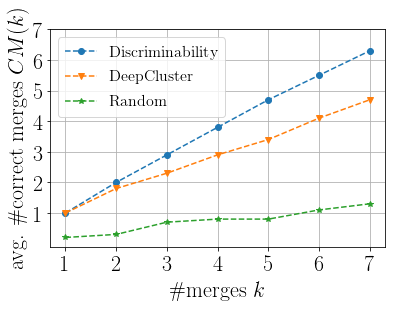

[0 1 2 3 4 5 6 7 8 9] 10
Discriminability #Correct Merges after 7 Merges:
 [6 7 7 5 7 6 5 6 7 7]
[0 1 2 3 4 5 6 7 8 9] 10
DeepCluster #Correct Merges after 7 Merges:
 [4 3 7 5 5 3 3 4 7 6]


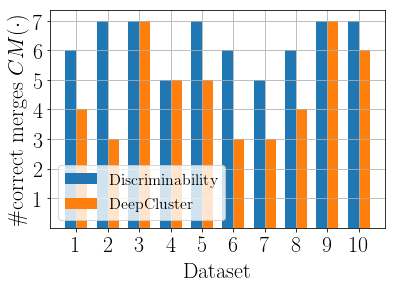

In [4]:
num_correct_merges_array = np.array(num_correct_merges_by_affinity_type)
labels = ['Discriminability', 'DeepCluster', 'Random']

# Correct Merges averaged over all datasets
markers = ['o--', 'v--', '*--']
for index, label in enumerate(labels):
    num_correct_merges_of_affinity_type = num_correct_merges_array[index]
    average_num_correct_merges = np.mean(num_correct_merges_of_affinity_type, axis=0)
    print(label, '#Correct Merges per dataset:\n', num_correct_merges_of_affinity_type)
    print(label, 'Average #Correct Merges:\n', average_num_correct_merges)
    plt.plot(np.arange(1, len(average_num_correct_merges) + 1),
             average_num_correct_merges,
             markers[index],
             label=label)
plt.grid(True)
plt.xticks(np.arange(1, len(average_num_correct_merges) + 1))
plt.yticks(np.arange(1, len(average_num_correct_merges) + 1))
plt.ylabel('avg. \#correct merges $CM(k)$')
plt.xlabel('\#merges $k$')
plt.legend(labels, fontsize=16)
plt.savefig(figure_path + '/average_num_correct_merges.pdf', bbox_inches='tight')
plt.show()

# Correct Merges on a per dataset basis
fig, ax = plt.subplots()

positions = np.arange(10)
bar_width = 0.35

for index, label in enumerate(labels[:2]):
    print(positions, len(num_correct_merges_of_affinity_type[:,-1]))
    num_correct_merges_of_affinity_type = num_correct_merges_array[index]
    print(label, '#Correct Merges after 7 Merges:\n', num_correct_merges_of_affinity_type[:,-1])
    ax.bar(positions + index * bar_width, num_correct_merges_of_affinity_type[:,-1], bar_width, label=label)

ax.set_xlabel('Dataset')
ax.set_ylabel('\#correct merges $CM(\cdot)$')
ax.set_xticks(positions + bar_width / 2)
ax.set_xticklabels(positions + 1)
ax.set_yticks(np.arange(1, 8))
ax.grid(True)
ax.legend(fontsize=16, loc=3)
    
plt.savefig(figure_path +  '/num_correct_merges_per_dataset.pdf', bbox_inches='tight')
plt.show()

# Analysis of Initial Clusterings

Dataset 1 Purity: 1825/2000 (91.2%) #Unique majority categories 8


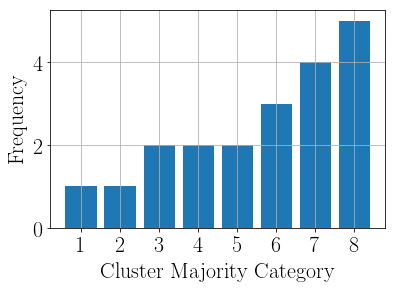

Dataset 2 Purity: 1837/2000 (91.8%) #Unique majority categories 8


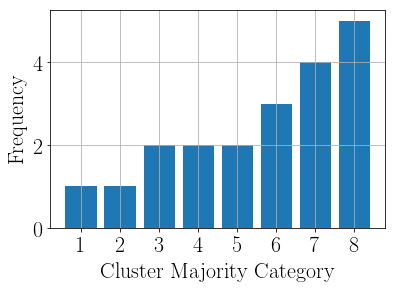

Dataset 3 Purity: 1807/2000 (90.3%) #Unique majority categories 6


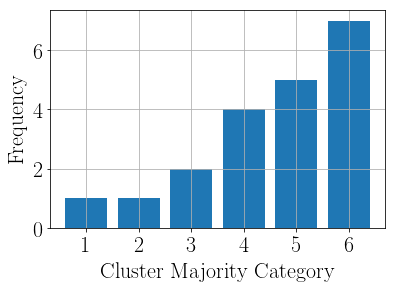

Dataset 4 Purity: 1855/2000 (92.8%) #Unique majority categories 7


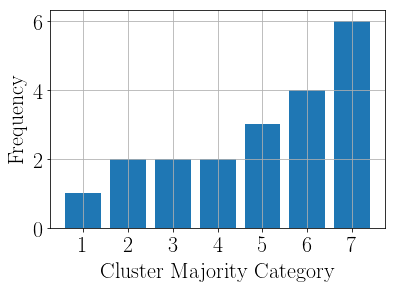

Dataset 5 Purity: 1889/2000 (94.5%) #Unique majority categories 7


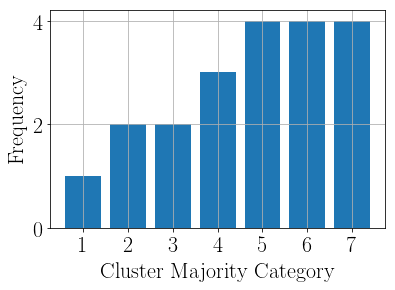

Dataset 6 Purity: 1833/2000 (91.7%) #Unique majority categories 9


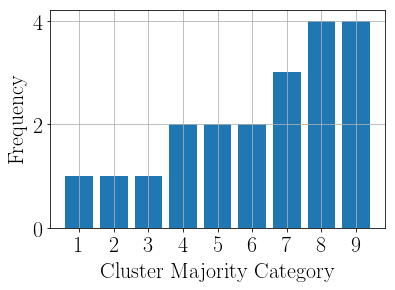

Dataset 7 Purity: 1781/2000 (89.0%) #Unique majority categories 9


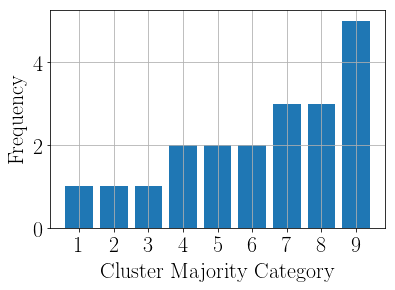

Dataset 8 Purity: 1788/2000 (89.4%) #Unique majority categories 8


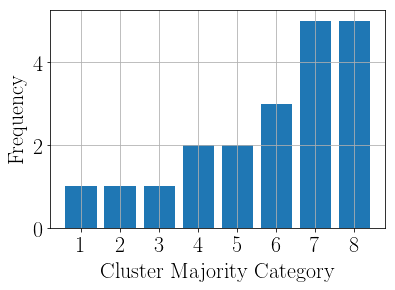

Dataset 9 Purity: 1906/2000 (95.3%) #Unique majority categories 8


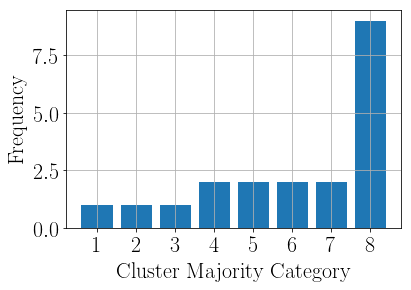

Dataset 10 Purity: 1927/2000 (96.3%) #Unique majority categories 7


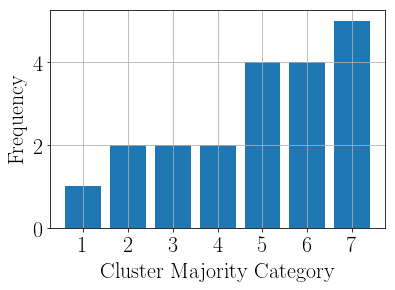

In [5]:
for dataset_index in range(num_datasets):
    # The affinity measure does not matter here because here only the initial clustering is evaluated which
    # is the same for all affinity measures in this experiment series.
    experiment_filename = 'results/3-experiment/imagenet-{}/20x100_averagelinkage.json'.format(
        dataset_index)
    with open(experiment_filename) as experiment_file:
        experiment = json.load(experiment_file)
    dataset = datasets.ImageFolder('./datasets/' + experiment['hp']['dataset'])
    initial_clustering = experiment['result']['initial_clustering']

    count_majority_total = count_total = 0
    majority_categories = []
    for sample_indices_i in initial_clustering:
        cluster_i_categories = Counter(utils.get_categories(dataset, sample_indices_i))
        majority_category, count_majority_category = cluster_i_categories.most_common(1)[0]
        count_majority_total += count_majority_category
        count_total += len(sample_indices_i)
        majority_categories.append(majority_category)
    
    print('Dataset', dataset_index + 1,
          'Purity:', utils.pretty_accuracy(count_majority_total, count_total),
          '#Unique majority categories', len(set(majority_categories)))
    
    sorted_majority_category_counts = sorted(Counter(majority_categories).values())
    plt.bar(range(1, len(sorted_majority_category_counts) + 1),
            sorted_majority_category_counts)
    plt.xlabel('Cluster Majority Category')
    plt.ylabel('Frequency')
    plt.xticks(np.arange(1, len(sorted_majority_category_counts) + 1))
    plt.grid(True)
    plt.savefig(figure_path + '/' + experiment['hp']['dataset'] + '_majority_category_distribution.pdf',
                bbox_inches='tight')
    plt.show()